# 🏭 Predictive Maintenance - Machine Failure Prediction Analysis

## 프로젝트 개요
- **목적**: 설비 센서 데이터 기반 고장 예측 모델 개발
- **데이터**: predictive_maintenance.csv (10,000 records)
- **목표**: 최적 성능 + 오버피팅 방지 모델 선정

## 분석 프로세스
1. 라이브러리 임포트 및 데이터 로드
2. 탐색적 데이터 분석 (EDA)
3. 데이터 전처리 및 Feature Engineering
4. 다중 모델 학습 및 비교
5. 모델 평가 및 선정
6. 최종 모델 저장

## 1. 라이브러리 임포트

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Advanced Models
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Imbalanced Data Handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Hyperparameter Tuning
import optuna

# Utilities
import joblib
from datetime import datetime

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("✅ All libraries imported successfully")
print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All libraries imported successfully
Analysis started at: 2025-11-19 01:22:45


## 2. 데이터 로드 및 기본 정보

In [2]:
# Load data
df = pd.read_csv('predictive_maintenance.csv')

print("📊 Dataset Shape:", df.shape)
print("\n" + "="*80)
print("First 5 rows:")
df.head()

📊 Dataset Shape: (10000, 10)

First 5 rows:


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [3]:
# Basic information
print("📋 Dataset Info:")
print("="*80)
df.info()

print("\n" + "="*80)
print("Statistical Summary:")
df.describe()

📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB

Statistical Summary:


,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [4]:
# Check for missing values
print("🔍 Missing Values:")
print("="*80)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

if missing.sum() == 0:
    print("✅ No missing values found!")

🔍 Missing Values:
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []
✅ No missing values found!


In [5]:
# Check duplicates
duplicates = df.duplicated().sum()
print(f"🔄 Duplicate rows: {duplicates}")

# Check unique values for categorical columns
print("\n" + "="*80)
print("Categorical Features Analysis:")
print("="*80)
print(f"Product Type: {df['Type'].value_counts().to_dict()}")
print(f"\nTarget Distribution: {df['Target'].value_counts().to_dict()}")
print(f"\nFailure Types: {df['Failure Type'].value_counts().to_dict()}")

🔄 Duplicate rows: 0

Categorical Features Analysis:
Product Type: {'L': 6000, 'M': 2997, 'H': 1003}

Target Distribution: {0: 9661, 1: 339}

Failure Types: {'No Failure': 9652, 'Heat Dissipation Failure': 112, 'Power Failure': 95, 'Overstrain Failure': 78, 'Tool Wear Failure': 45, 'Random Failures': 18}


## 3. 탐색적 데이터 분석 (EDA)

### 3.1 Target Variable Distribution

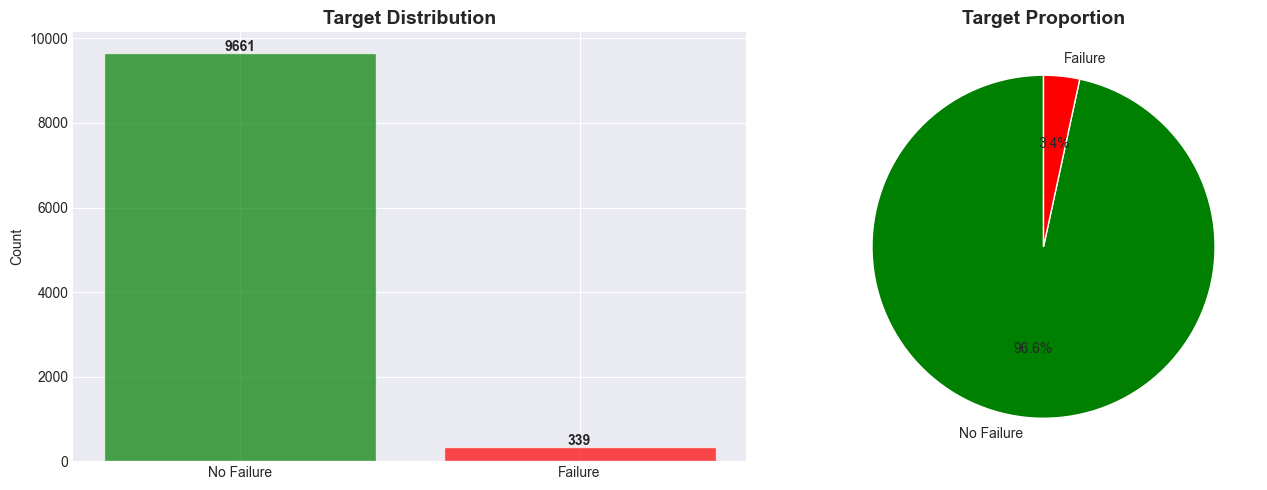

⚠️ Class Imbalance Ratio: 28.50:1
⚠️ This is highly imbalanced dataset


In [6]:
# Target distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
target_counts = df['Target'].value_counts()
axes[0].bar(['No Failure', 'Failure'], target_counts.values, color=['green', 'red'], alpha=0.7)
axes[0].set_title('Target Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(target_counts.values, labels=['No Failure', 'Failure'], 
            autopct='%1.1f%%', colors=['green', 'red'], startangle=90)
axes[1].set_title('Target Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate imbalance ratio
imbalance_ratio = target_counts[0] / target_counts[1]
print(f"⚠️ Class Imbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"⚠️ This is {'highly' if imbalance_ratio > 10 else 'moderately'} imbalanced dataset")

### 3.2 Failure Type Analysis

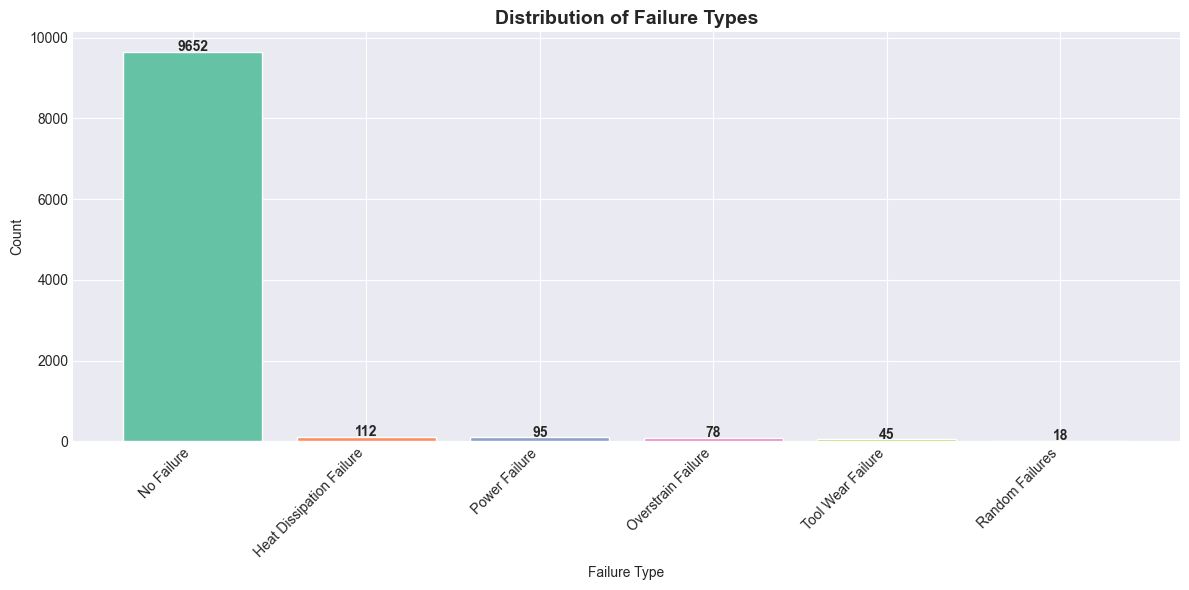


Failure Type Statistics:
Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64


In [7]:
# Failure type distribution
failure_counts = df['Failure Type'].value_counts()

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(failure_counts)), failure_counts.values, 
               color=sns.color_palette('Set2', len(failure_counts)))
plt.xticks(range(len(failure_counts)), failure_counts.index, rotation=45, ha='right')
plt.title('Distribution of Failure Types', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.xlabel('Failure Type')

for i, (bar, count) in enumerate(zip(bars, failure_counts.values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
             str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nFailure Type Statistics:")
print(failure_counts)

### 3.3 Product Type Analysis

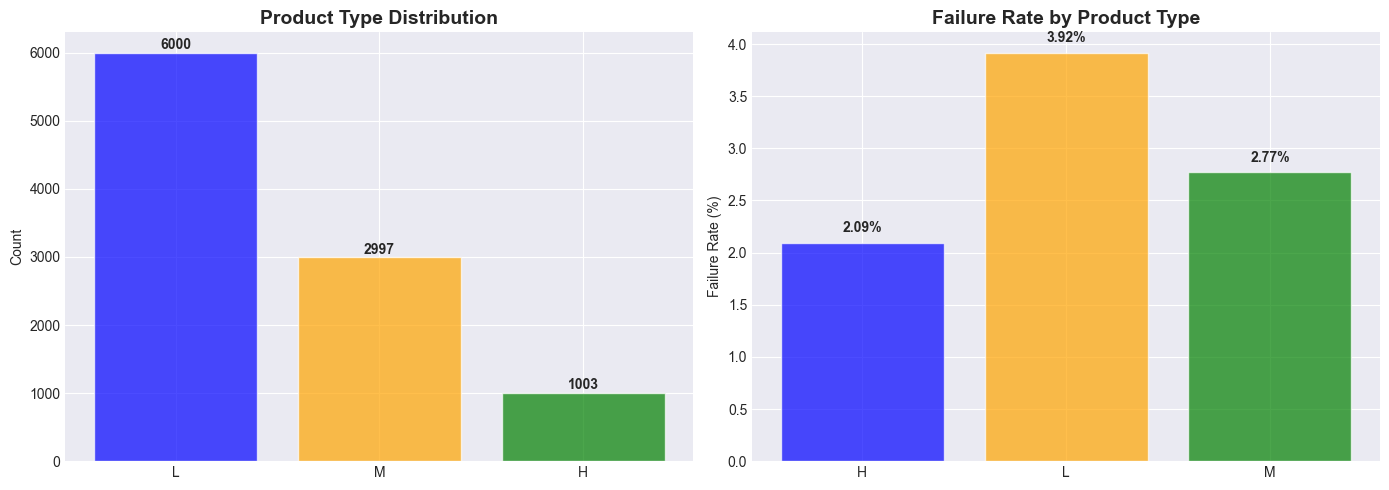


Failure Rate by Product Type:
      sum  count  failure_rate
Type                          
H      21   1003      2.093719
L     235   6000      3.916667
M      83   2997      2.769436


In [8]:
# Product type vs Target
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Product type distribution
type_counts = df['Type'].value_counts()
axes[0].bar(type_counts.index, type_counts.values, color=['blue', 'orange', 'green'], alpha=0.7)
axes[0].set_title('Product Type Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
for i, (idx, v) in enumerate(type_counts.items()):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Product type vs failure rate
type_failure = df.groupby('Type')['Target'].agg(['sum', 'count'])
type_failure['failure_rate'] = (type_failure['sum'] / type_failure['count']) * 100

axes[1].bar(type_failure.index, type_failure['failure_rate'], 
            color=['blue', 'orange', 'green'], alpha=0.7)
axes[1].set_title('Failure Rate by Product Type', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Failure Rate (%)')
for i, (idx, rate) in enumerate(type_failure['failure_rate'].items()):
    axes[1].text(i, rate + 0.1, f'{rate:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nFailure Rate by Product Type:")
print(type_failure)

### 3.4 Numerical Features Distribution

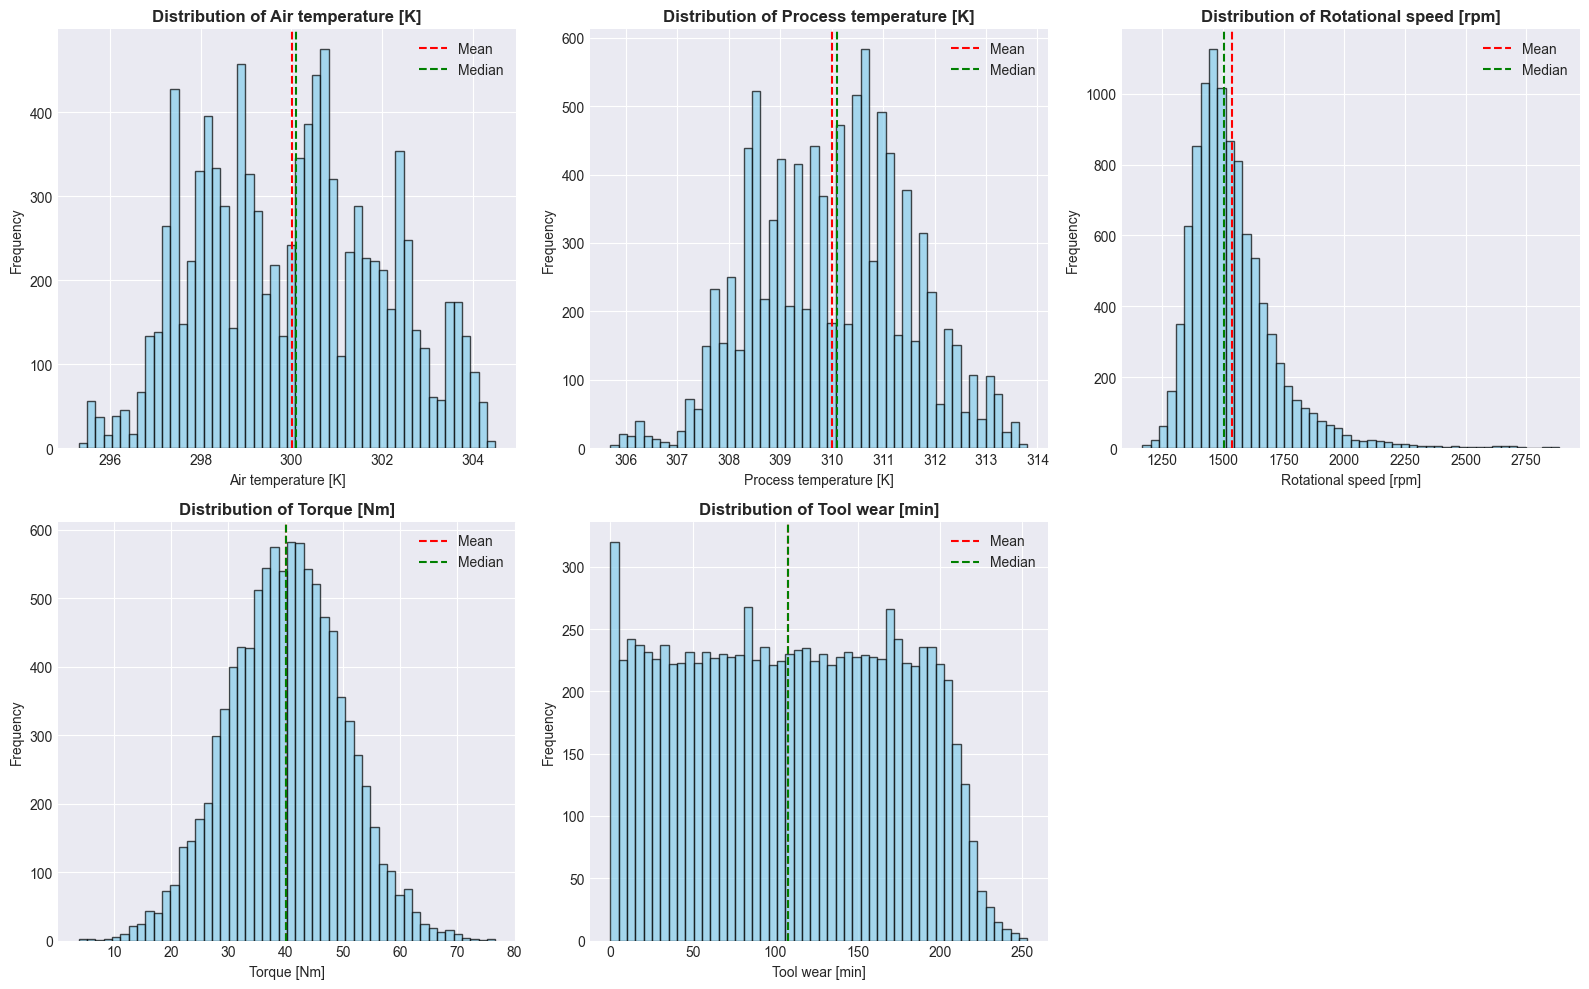

In [9]:
       # Select numerical features
numerical_features = ['Air temperature [K]', 'Process temperature [K]',
                      'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Distribution plots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(numerical_features):
    axes[idx].hist(df[col], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}', fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].axvline(df[col].mean(), color='red', linestyle='--', label='Mean')
    axes[idx].axvline(df[col].median(), color='green', linestyle='--', label='Median')
    axes[idx].legend()

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

# Note: After Feature Engineering, these will be renamed to remove special characters
numerical_features_renamed = ['Air_temperature_K', 'Process_temperature_K',
                              'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min']

### 3.5 Correlation Analysis

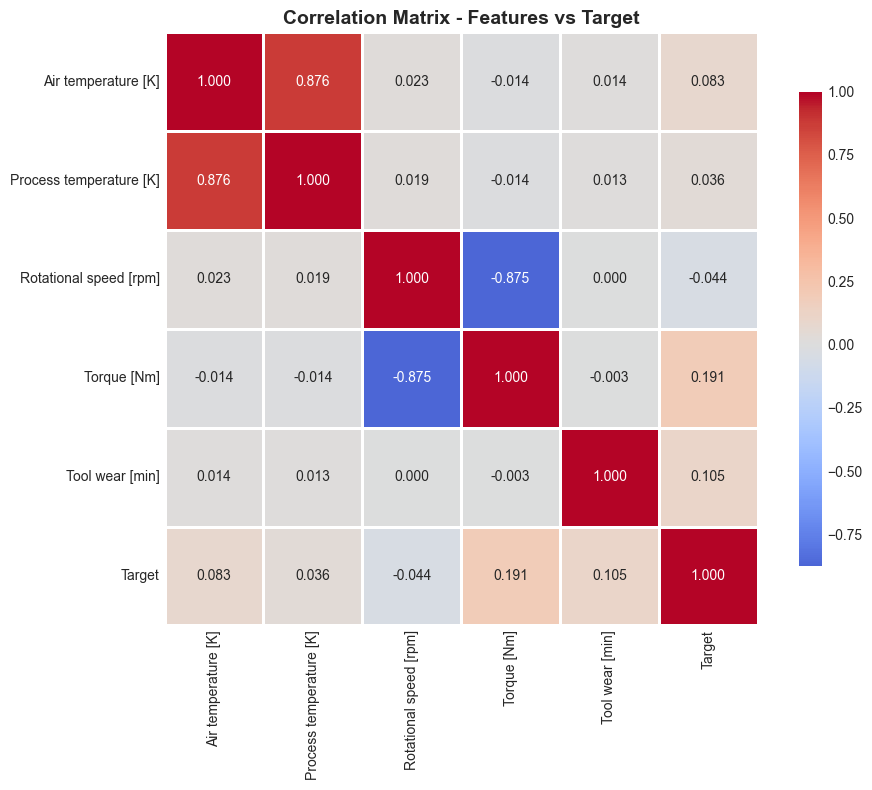


📊 Correlation with Target:
Target                     1.000000
Torque [Nm]                0.191321
Tool wear [min]            0.105448
Air temperature [K]        0.082556
Process temperature [K]    0.035946
Rotational speed [rpm]    -0.044188
Name: Target, dtype: float64


In [10]:
# Correlation matrix
correlation_data = df[numerical_features + ['Target']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Features vs Target', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Correlation with Target:")
print("="*80)
target_corr = correlation_data['Target'].sort_values(ascending=False)
print(target_corr)

### 3.6 Feature vs Target Analysis

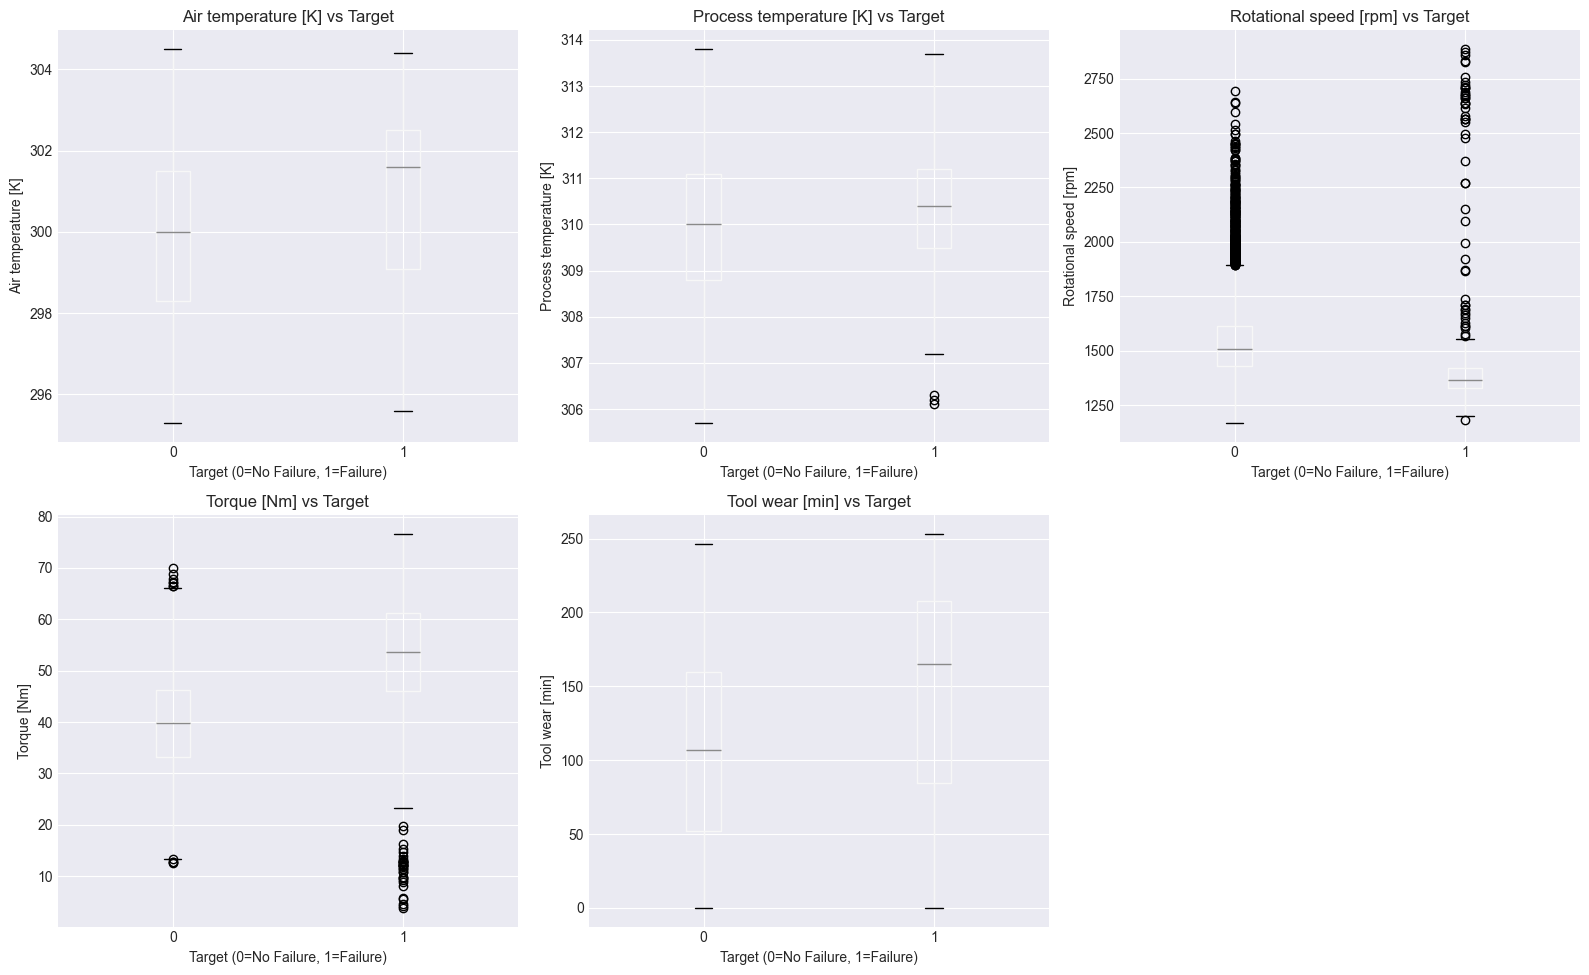

In [11]:
# Box plots for numerical features vs Target
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(numerical_features):
    df.boxplot(column=col, by='Target', ax=axes[idx])
    axes[idx].set_title(f'{col} vs Target')
    axes[idx].set_xlabel('Target (0=No Failure, 1=Failure)')
    axes[idx].set_ylabel(col)

# Remove extra subplot
fig.delaxes(axes[5])

plt.suptitle('')
plt.tight_layout()
plt.show()

### 3.7 Outlier Detection

In [12]:
# Outlier detection using IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

print("🔍 Outlier Analysis (IQR Method):")
print("="*80)

outlier_summary = []
for col in numerical_features:
    count, lower, upper = detect_outliers_iqr(df, col)
    outlier_pct = (count / len(df)) * 100
    outlier_summary.append({
        'Feature': col,
        'Outlier Count': count,
        'Percentage': f'{outlier_pct:.2f}%',
        'Lower Bound': f'{lower:.2f}',
        'Upper Bound': f'{upper:.2f}'
    })

outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df.to_string(index=False))

🔍 Outlier Analysis (IQR Method):
                Feature  Outlier Count Percentage Lower Bound Upper Bound
    Air temperature [K]              0      0.00%      293.50      306.30
Process temperature [K]              0      0.00%      305.35      314.55
 Rotational speed [rpm]            418      4.18%     1139.50     1895.50
            Torque [Nm]             69      0.69%       12.80       67.20
        Tool wear [min]              0      0.00%     -110.50      325.50


## 4. Data Preprocessing & Feature Engineering

### 4.1 Feature Engineering

In [13]:
# Create a copy for processing
df_processed = df.copy()

print("🔧 Feature Engineering...")
print("="*80)

# 1. Temperature difference
df_processed['Temp_diff'] = df_processed['Process temperature [K]'] - df_processed['Air temperature [K]']
print("✅ Created: Temp_diff (Process - Air temperature)")

# 2. Power (Torque * Rotational speed)
df_processed['Power'] = df_processed['Torque [Nm]'] * df_processed['Rotational speed [rpm]'] / 1000
print("✅ Created: Power (Torque × Rotational speed / 1000)")

# 3. Tool wear rate
df_processed['Tool_wear_rate'] = df_processed['Tool wear [min]'] / (df_processed['Rotational speed [rpm]'] + 1)
print("✅ Created: Tool_wear_rate (Tool wear / Rotational speed)")

# 4. Torque to speed ratio
df_processed['Torque_speed_ratio'] = df_processed['Torque [Nm]'] / (df_processed['Rotational speed [rpm]'] + 1)
print("✅ Created: Torque_speed_ratio (Torque / Rotational speed)")

# 5. Temperature × Tool wear interaction
df_processed['Temp_toolwear'] = df_processed['Process temperature [K]'] * df_processed['Tool wear [min]']
print("✅ Created: Temp_toolwear (Temperature × Tool wear)")

# 6. Encode Product Type
le_type = LabelEncoder()
df_processed['Type_encoded'] = le_type.fit_transform(df_processed['Type'])
print("✅ Created: Type_encoded (Label encoded Product Type)")
print(f"   Encoding mapping: {dict(zip(le_type.classes_, le_type.transform(le_type.classes_)))}")

print(f"\n📊 New shape: {df_processed.shape}")
print(f"📊 New features added: {df_processed.shape[1] - df.shape[1]}")

# Fix column names for XGBoost compatibility
print("\n🔧 Fixing column names for XGBoost...")
print("="*80)
column_rename_mapping = {
    'Air temperature [K]': 'Air_temperature_K',
    'Process temperature [K]': 'Process_temperature_K',
    'Rotational speed [rpm]': 'Rotational_speed_rpm',
    'Torque [Nm]': 'Torque_Nm',
    'Tool wear [min]': 'Tool_wear_min'
}

df_processed = df_processed.rename(columns=column_rename_mapping)
print(f"✅ Column names fixed: {len(column_rename_mapping)} columns renamed")
print("\nNew column names (no special characters):")
for old, new in column_rename_mapping.items():
    print(f"  • {old} → {new}")

🔧 Feature Engineering...
✅ Created: Temp_diff (Process - Air temperature)
✅ Created: Power (Torque × Rotational speed / 1000)
✅ Created: Tool_wear_rate (Tool wear / Rotational speed)
✅ Created: Torque_speed_ratio (Torque / Rotational speed)
✅ Created: Temp_toolwear (Temperature × Tool wear)
✅ Created: Type_encoded (Label encoded Product Type)
   Encoding mapping: {'H': np.int64(0), 'L': np.int64(1), 'M': np.int64(2)}

📊 New shape: (10000, 16)
📊 New features added: 6

🔧 Fixing column names for XGBoost...
✅ Column names fixed: 5 columns renamed

New column names (no special characters):
  • Air temperature [K] → Air_temperature_K
  • Process temperature [K] → Process_temperature_K
  • Rotational speed [rpm] → Rotational_speed_rpm
  • Torque [Nm] → Torque_Nm
  • Tool wear [min] → Tool_wear_min


### 4.2 Feature Selection

In [14]:
# Define feature columns (excluding non-predictive columns)
exclude_cols = ['UDI', 'Product ID', 'Type', 'Target', 'Failure Type']
feature_cols = [col for col in df_processed.columns if col not in exclude_cols]

print("📋 Selected Features for Modeling:")
print("="*80)
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2d}. {col}")

print(f"\nTotal features: {len(feature_cols)}")

📋 Selected Features for Modeling:
 1. Air_temperature_K
 2. Process_temperature_K
 3. Rotational_speed_rpm
 4. Torque_Nm
 5. Tool_wear_min
 6. Temp_diff
 7. Power
 8. Tool_wear_rate
 9. Torque_speed_ratio
10. Temp_toolwear
11. Type_encoded

Total features: 11


### 4.3 Train-Test Split

In [15]:
# Prepare X and y
X = df_processed[feature_cols]
y = df_processed['Target']

# Split data (stratified to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✂️ Data Split Summary:")
print("="*80)
print(f"Train set: {X_train.shape[0]} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]} samples ({X_test.shape[0]/len(df)*100:.1f}%)")
print(f"\nTrain target distribution:\n{y_train.value_counts()}")
print(f"\nTest target distribution:\n{y_test.value_counts()}")

✂️ Data Split Summary:
Train set: 8000 samples (80.0%)
Test set:  2000 samples (20.0%)

Train target distribution:
Target
0    7729
1     271
Name: count, dtype: int64

Test target distribution:
Target
0    1932
1      68
Name: count, dtype: int64


### 4.4 Feature Scaling

In [16]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for better readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print("📏 Feature Scaling Complete (StandardScaler)")
print("="*80)
print("Scaled train data sample:")
print(X_train_scaled.head())
print(f"\nMean: {X_train_scaled.mean().mean():.6f}")
print(f"Std:  {X_train_scaled.std().mean():.6f}")

📏 Feature Scaling Complete (StandardScaler)
Scaled train data sample:
      Air_temperature_K  Process_temperature_K  Rotational_speed_rpm  \
4058           0.998914               0.604282             -0.460607   
1221          -1.505194              -1.153260             -0.775574   
6895           0.498092               1.077466             -1.007654   
9863          -0.553633              -0.139294             -0.709265   
8711          -1.455112              -1.018064              1.070019   

      Torque_Nm  Tool_wear_min  Temp_diff     Power  Tool_wear_rate  \
4058   0.718305      -0.843997  -1.100842  0.852387       -0.791384   
1221   0.638456       0.382263   1.299658  0.480363        0.554412   
6895   0.558607       0.460870   0.599512  0.184041        0.709585   
9863   1.626586      -0.372359   0.899575  1.898861       -0.263924   
8711  -1.128202      -0.906882   1.399679 -1.001687       -0.984879   

      Torque_speed_ratio  Temp_toolwear  Type_encoded  
4058          

### 4.5 Handle Class Imbalance (SMOTE)

In [17]:
# Apply SMOTE to training data
print("⚖️ Handling Class Imbalance with SMOTE...")
print("="*80)
print(f"Before SMOTE: {y_train.value_counts().to_dict()}")

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"After SMOTE:  {pd.Series(y_train_balanced).value_counts().to_dict()}")
print(f"\n✅ Training data balanced: {len(X_train_balanced)} samples")

⚖️ Handling Class Imbalance with SMOTE...
Before SMOTE: {0: 7729, 1: 271}
After SMOTE:  {0: 7729, 1: 7729}

✅ Training data balanced: 15458 samples


## 5. Model Training & Comparison

### 5.1 Define Models

In [18]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
    'CatBoost': CatBoostClassifier(iterations=100, random_state=42, verbose=0),
    'SVM': SVC(kernel='rbf', random_state=42, probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

print("🤖 Models to be trained:")
print("="*80)
for i, model_name in enumerate(models.keys(), 1):
    print(f"{i}. {model_name}")

🤖 Models to be trained:
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. Gradient Boosting
5. XGBoost
6. LightGBM
7. CatBoost
8. SVM
9. KNN


### 5.2 Train Models and Evaluate

In [19]:
# Storage for results
results = []
trained_models = {}

print("🚀 Training models...")
print("="*80)

for name, model in models.items():
    print(f"\n📊 Training {name}...")
    
    # Train model
    model.fit(X_train_balanced, y_train_balanced)
    
    # Predictions
    y_train_pred = model.predict(X_train_balanced)
    y_test_pred = model.predict(X_test_scaled)
    
    # Probabilities for ROC-AUC
    if hasattr(model, 'predict_proba'):
        y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
        test_auc = roc_auc_score(y_test, y_test_proba)
    else:
        test_auc = None
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train_balanced, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    # Overfitting check
    overfit_diff = train_accuracy - test_accuracy
    
    # Store results
    results.append({
        'Model': name,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Precision': test_precision,
        'Recall': test_recall,
        'F1-Score': test_f1,
        'ROC-AUC': test_auc,
        'Overfit (Train-Test)': overfit_diff
    })
    
    # Store trained model
    trained_models[name] = model
    
    print(f"   ✅ Test Accuracy: {test_accuracy:.4f} | F1: {test_f1:.4f} | Overfit: {overfit_diff:.4f}")

print("\n✅ All models trained successfully!")

🚀 Training models...

📊 Training Logistic Regression...
   ✅ Test Accuracy: 0.8640 | F1: 0.3026 | Overfit: -0.0110

📊 Training Decision Tree...
   ✅ Test Accuracy: 0.9680 | F1: 0.6235 | Overfit: 0.0320

📊 Training Random Forest...
   ✅ Test Accuracy: 0.9760 | F1: 0.7073 | Overfit: 0.0240

📊 Training Gradient Boosting...
   ✅ Test Accuracy: 0.9450 | F1: 0.5299 | Overfit: 0.0246

📊 Training XGBoost...
   ✅ Test Accuracy: 0.9800 | F1: 0.7436 | Overfit: 0.0199

📊 Training LightGBM...
   ✅ Test Accuracy: 0.9785 | F1: 0.7329 | Overfit: 0.0208

📊 Training CatBoost...
   ✅ Test Accuracy: 0.9670 | F1: 0.6374 | Overfit: 0.0221

📊 Training SVM...
   ✅ Test Accuracy: 0.9265 | F1: 0.4535 | Overfit: 0.0291

📊 Training KNN...
   ✅ Test Accuracy: 0.9385 | F1: 0.4533 | Overfit: 0.0416

✅ All models trained successfully!


### 5.3 Results Comparison

In [20]:
# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test Accuracy', ascending=False)

print("\n📊 Model Comparison Results:")
print("="*120)
print(results_df.to_string(index=False))

# Identify best model
best_model_name = results_df.iloc[0]['Model']
print(f"\n🏆 Best Model (by Test Accuracy): {best_model_name}")
print(f"   Test Accuracy: {results_df.iloc[0]['Test Accuracy']:.4f}")
print(f"   F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")
print(f"   Overfitting: {results_df.iloc[0]['Overfit (Train-Test)']:.4f}")


📊 Model Comparison Results:
              Model  Train Accuracy  Test Accuracy  Precision   Recall  F1-Score  ROC-AUC  Overfit (Train-Test)
            XGBoost        0.999871         0.9800   0.659091 0.852941  0.743590 0.977842              0.019871
           LightGBM        0.999288         0.9785   0.634409 0.867647  0.732919 0.983323              0.020788
      Random Forest        1.000000         0.9760   0.604167 0.852941  0.707317 0.982052              0.024000
      Decision Tree        1.000000         0.9680   0.519608 0.779412  0.623529 0.877025              0.032000
           CatBoost        0.989132         0.9670   0.508772 0.852941  0.637363 0.981016              0.022132
  Gradient Boosting        0.969595         0.9450   0.373494 0.911765  0.529915 0.972385              0.024595
                KNN        0.980140         0.9385   0.324841 0.750000  0.453333 0.901378              0.041640
                SVM        0.955622         0.9265   0.303483 0.897059  0.4

### 5.4 Visualize Model Performance

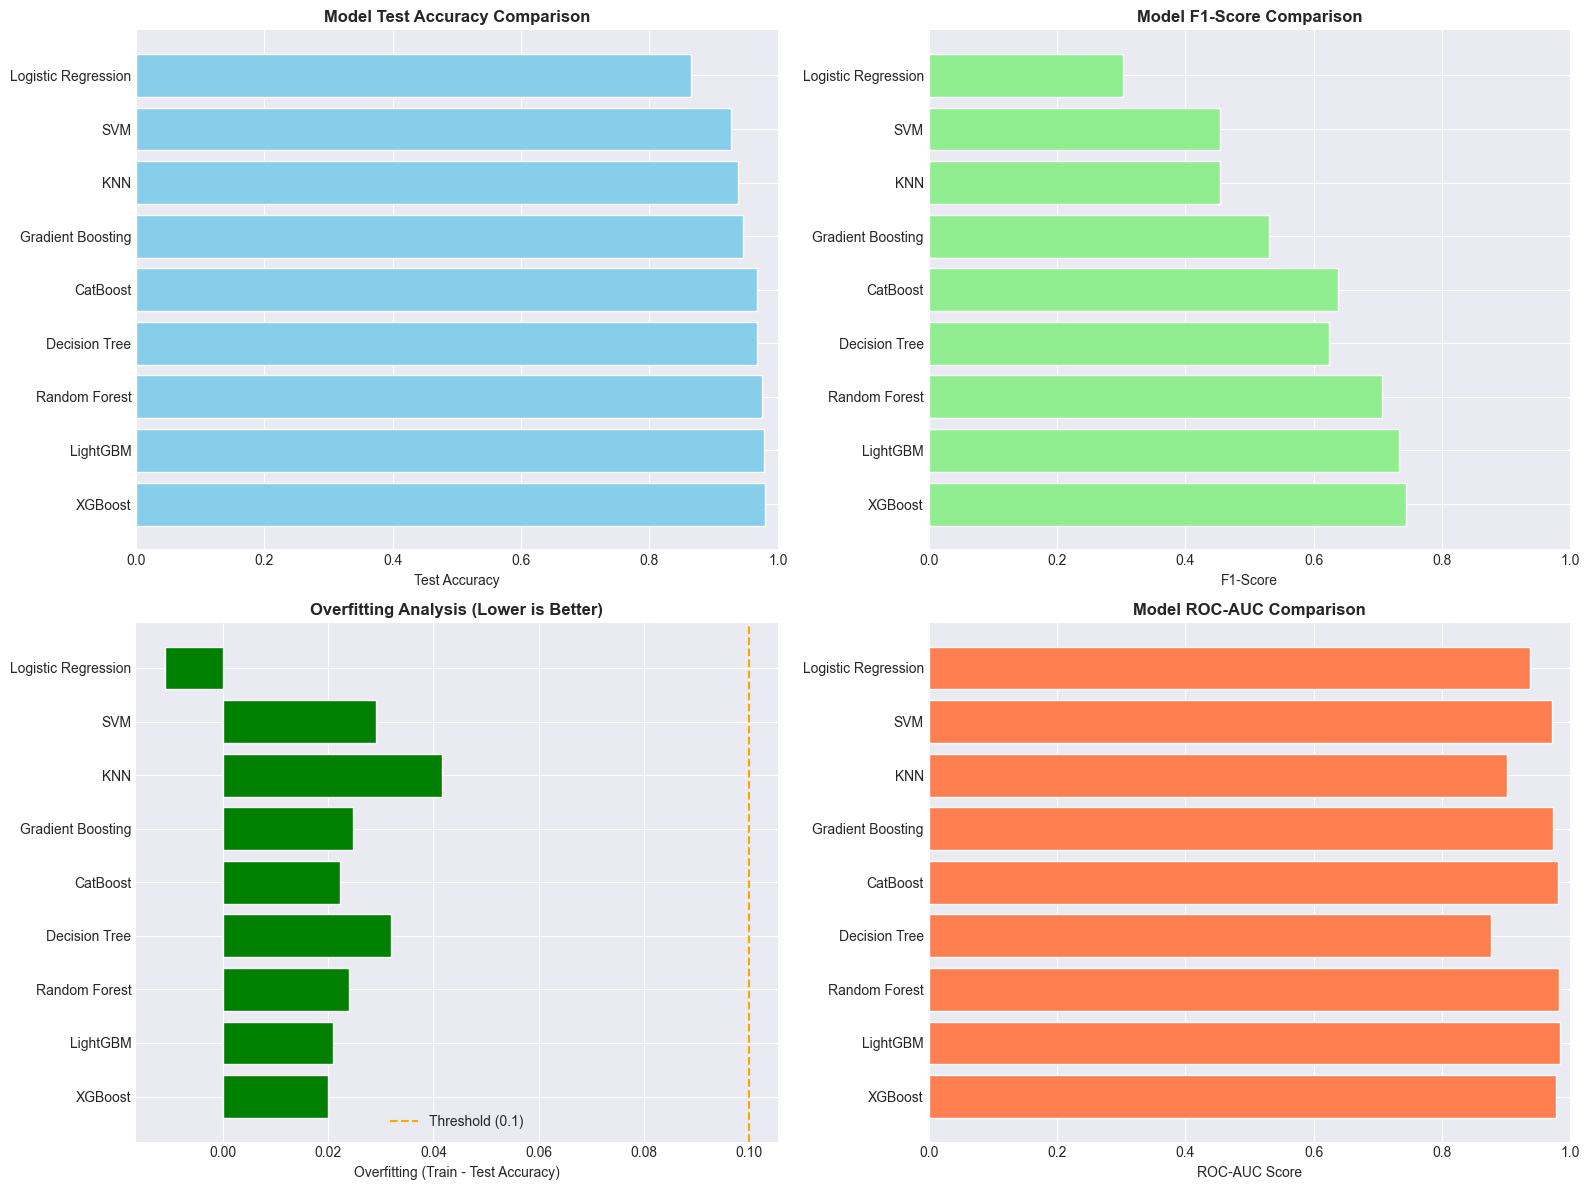

In [21]:
# Performance comparison plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Test Accuracy
axes[0, 0].barh(results_df['Model'], results_df['Test Accuracy'], color='skyblue')
axes[0, 0].set_xlabel('Test Accuracy')
axes[0, 0].set_title('Model Test Accuracy Comparison', fontweight='bold')
axes[0, 0].set_xlim(0, 1)

# 2. F1-Score
axes[0, 1].barh(results_df['Model'], results_df['F1-Score'], color='lightgreen')
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('Model F1-Score Comparison', fontweight='bold')
axes[0, 1].set_xlim(0, 1)

# 3. Overfitting Analysis
colors = ['red' if x > 0.1 else 'green' for x in results_df['Overfit (Train-Test)']]
axes[1, 0].barh(results_df['Model'], results_df['Overfit (Train-Test)'], color=colors)
axes[1, 0].set_xlabel('Overfitting (Train - Test Accuracy)')
axes[1, 0].set_title('Overfitting Analysis (Lower is Better)', fontweight='bold')
axes[1, 0].axvline(0.1, color='orange', linestyle='--', label='Threshold (0.1)')
axes[1, 0].legend()

# 4. ROC-AUC
roc_data = results_df[results_df['ROC-AUC'].notna()]
axes[1, 1].barh(roc_data['Model'], roc_data['ROC-AUC'], color='coral')
axes[1, 1].set_xlabel('ROC-AUC Score')
axes[1, 1].set_title('Model ROC-AUC Comparison', fontweight='bold')
axes[1, 1].set_xlim(0, 1)

plt.tight_layout()
plt.show()

### 5.5 Detailed Analysis of Best Models

🔍 Detailed Analysis of Top 3 Models:

📊 XGBoost

Classification Report:
              precision    recall  f1-score   support

  No Failure       0.99      0.98      0.99      1932
     Failure       0.66      0.85      0.74        68

    accuracy                           0.98      2000
   macro avg       0.83      0.92      0.87      2000
weighted avg       0.98      0.98      0.98      2000



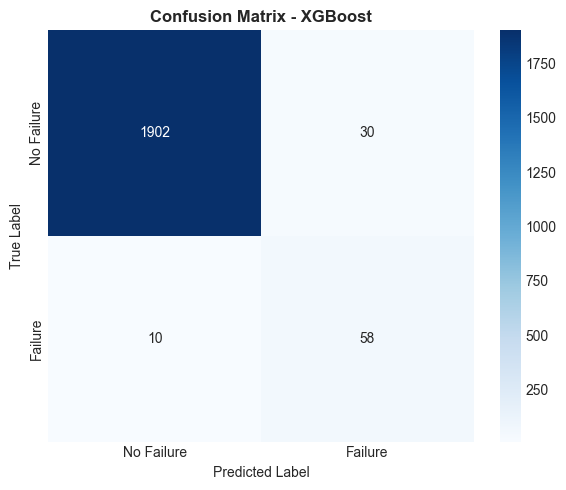


📊 LightGBM

Classification Report:
              precision    recall  f1-score   support

  No Failure       1.00      0.98      0.99      1932
     Failure       0.63      0.87      0.73        68

    accuracy                           0.98      2000
   macro avg       0.81      0.93      0.86      2000
weighted avg       0.98      0.98      0.98      2000



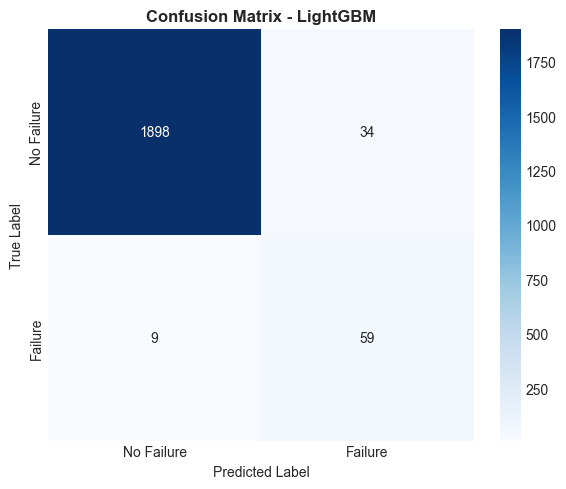


📊 Random Forest

Classification Report:
              precision    recall  f1-score   support

  No Failure       0.99      0.98      0.99      1932
     Failure       0.60      0.85      0.71        68

    accuracy                           0.98      2000
   macro avg       0.80      0.92      0.85      2000
weighted avg       0.98      0.98      0.98      2000



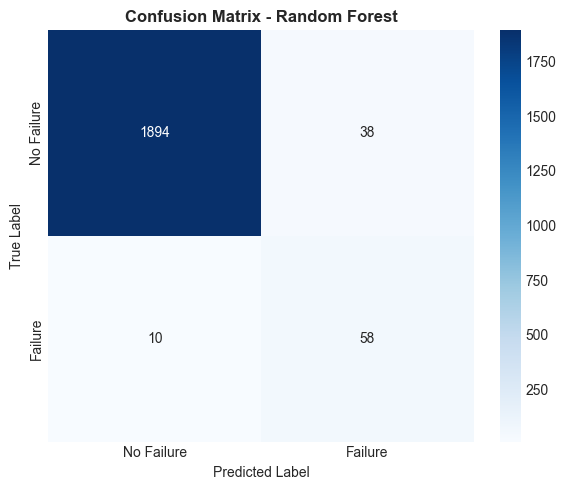

In [22]:
# Select top 3 models
top_3_models = results_df.head(3)['Model'].tolist()

print("🔍 Detailed Analysis of Top 3 Models:")
print("="*80)

for model_name in top_3_models:
    print(f"\n{'='*80}")
    print(f"📊 {model_name}")
    print("="*80)
    
    model = trained_models[model_name]
    y_pred = model.predict(X_test_scaled)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Failure', 'Failure']))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Failure', 'Failure'],
                yticklabels=['No Failure', 'Failure'])
    plt.title(f'Confusion Matrix - {model_name}', fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

### 5.6 ROC Curve Comparison

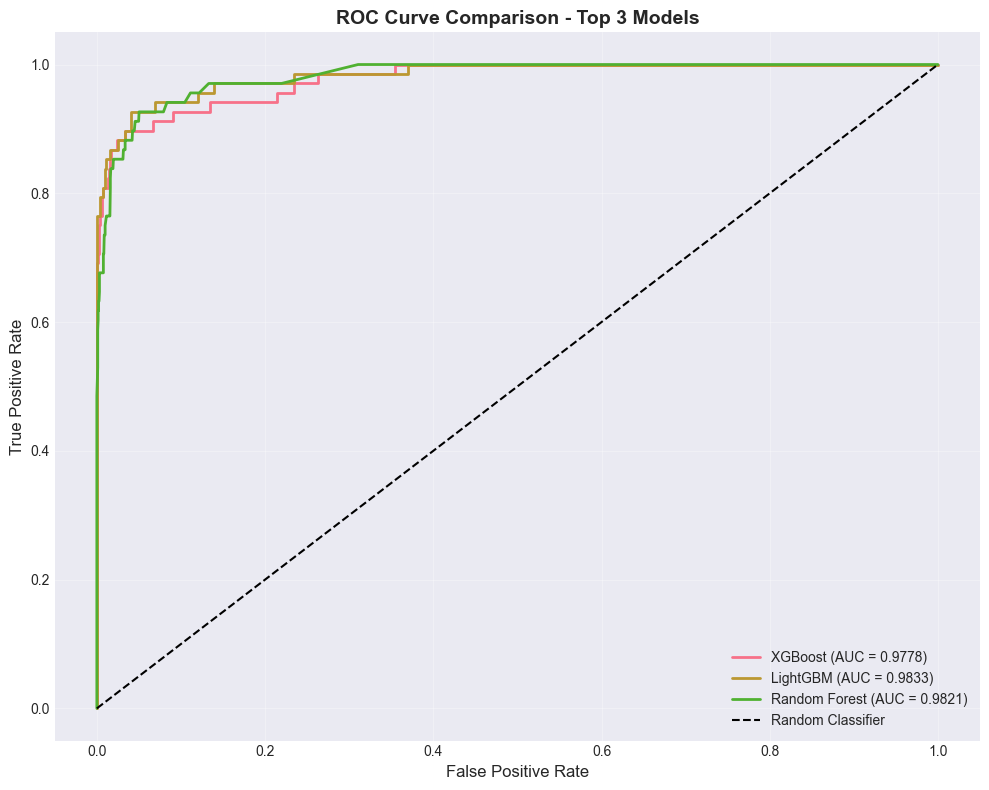

In [23]:
# Plot ROC curves for top models
plt.figure(figsize=(10, 8))

for model_name in top_3_models:
    model = trained_models[model_name]
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_score = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison - Top 3 Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 5.7 Feature Importance (for tree-based models)


🌳 Feature Importance Analysis - XGBoost
              Feature  Importance
   Torque_speed_ratio    0.381060
        Tool_wear_min    0.147271
                Power    0.143339
 Rotational_speed_rpm    0.092746
       Tool_wear_rate    0.075864
            Temp_diff    0.041446
         Type_encoded    0.038575
            Torque_Nm    0.028814
        Temp_toolwear    0.018100
Process_temperature_K    0.016565
    Air_temperature_K    0.016220


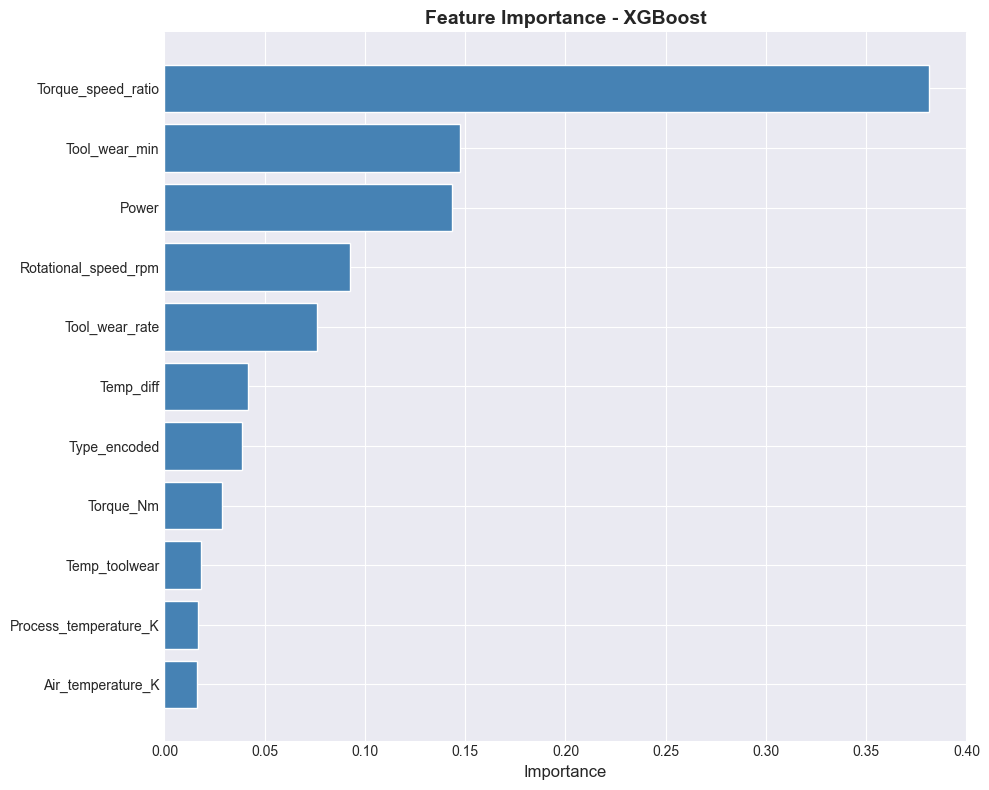

In [24]:
# Feature importance for best tree-based model
tree_based_models = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM', 'CatBoost']
best_tree_model = None

for model_name in top_3_models:
    if model_name in tree_based_models:
        best_tree_model = model_name
        break

if best_tree_model:
    print(f"\n🌳 Feature Importance Analysis - {best_tree_model}")
    print("="*80)
    
    model = trained_models[best_tree_model]
    
    # Get feature importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'get_feature_importance'):
        importances = model.get_feature_importance()
    
    # Create DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print(feature_importance_df.to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], 
             color='steelblue')
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Feature Importance - {best_tree_model}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## 6. Final Model Selection & Saving

### 6.1 Select Final Model

In [25]:
# Select best model based on combined criteria:
# 1. High Test Accuracy
# 2. High F1-Score (important for imbalanced data)
# 3. Low overfitting (Train-Test difference < 0.1)

# Filter models with acceptable overfitting
acceptable_models = results_df[results_df['Overfit (Train-Test)'] < 0.1]

if len(acceptable_models) > 0:
    # Sort by F1-Score (more important for imbalanced data)
    final_model_name = acceptable_models.sort_values('F1-Score', ascending=False).iloc[0]['Model']
else:
    # If no model meets overfitting criteria, select best by F1
    final_model_name = results_df.sort_values('F1-Score', ascending=False).iloc[0]['Model']

final_model = trained_models[final_model_name]
final_results = results_df[results_df['Model'] == final_model_name].iloc[0]

print("\n" + "="*80)
print("🏆 FINAL MODEL SELECTION")
print("="*80)
print(f"\nSelected Model: {final_model_name}")
print("\nPerformance Metrics:")
print(f"  • Test Accuracy:  {final_results['Test Accuracy']:.4f}")
print(f"  • Precision:      {final_results['Precision']:.4f}")
print(f"  • Recall:         {final_results['Recall']:.4f}")
print(f"  • F1-Score:       {final_results['F1-Score']:.4f}")
print(f"  • ROC-AUC:        {final_results['ROC-AUC']:.4f}" if final_results['ROC-AUC'] else "")
print(f"  • Overfitting:    {final_results['Overfit (Train-Test)']:.4f}")
print("\n" + "="*80)


🏆 FINAL MODEL SELECTION

Selected Model: XGBoost

Performance Metrics:
  • Test Accuracy:  0.9800
  • Precision:      0.6591
  • Recall:         0.8529
  • F1-Score:       0.7436
  • ROC-AUC:        0.9778
  • Overfitting:    0.0199



### 6.2 Save Model & Artifacts

In [29]:
# Create models directory
import os
os.makedirs('models', exist_ok=True)

# Save final model
model_path = f'models/final_model_{final_model_name.replace(" ", "_").lower()}.pkl'
joblib.dump(final_model, model_path)
print(f"✅ Model saved: {model_path}")

# Save scaler
scaler_path = 'models/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler saved: {scaler_path}")

# Save label encoder
encoder_path = 'models/label_encoder_type.pkl'
joblib.dump(le_type, encoder_path)
print(f"✅ Label Encoder saved: {encoder_path}")

# Save feature names
feature_names_path = 'models/feature_names.pkl'
joblib.dump(feature_cols, feature_names_path)
print(f"✅ Feature names saved: {feature_names_path}")

# Save results summary
results_df.to_csv('models/model_comparison_results.csv', index=False)
print(f"✅ Results summary saved: models/model_comparison_results.csv")

print("\n🎉 All artifacts saved successfully!")

✅ Model saved: models/final_model_xgboost.pkl
✅ Scaler saved: models/scaler.pkl
✅ Label Encoder saved: models/label_encoder_type.pkl
✅ Feature names saved: models/feature_names.pkl
✅ Results summary saved: models/model_comparison_results.csv

🎉 All artifacts saved successfully!


### 6.3 Model Inference Example

In [27]:
# Example: Load and use the model for prediction
print("\n📝 Model Inference Example:")
print("="*80)

# Take a sample from test set
sample_idx = 0
sample_data = X_test.iloc[sample_idx:sample_idx+1]
true_label = y_test.iloc[sample_idx]

print("\nInput Features:")
print(sample_data.T)

# Scale the sample
sample_scaled = scaler.transform(sample_data)

# Make prediction
prediction = final_model.predict(sample_scaled)[0]
if hasattr(final_model, 'predict_proba'):
    probability = final_model.predict_proba(sample_scaled)[0]
    print(f"\nPrediction Probabilities:")
    print(f"  No Failure: {probability[0]:.4f}")
    print(f"  Failure:    {probability[1]:.4f}")

print(f"\nPredicted: {'Failure' if prediction == 1 else 'No Failure'}")
print(f"Actual:    {'Failure' if true_label == 1 else 'No Failure'}")
print(f"Result:    {'✅ Correct' if prediction == true_label else '❌ Incorrect'}")


📝 Model Inference Example:

Input Features:
                               2997
Air_temperature_K        300.500000
Process_temperature_K    309.800000
Rotational_speed_rpm    1345.000000
Torque_Nm                 62.700000
Tool_wear_min            153.000000
Temp_diff                  9.300000
Power                     84.331500
Tool_wear_rate             0.113670
Torque_speed_ratio         0.046582
Temp_toolwear          47399.400000
Type_encoded               1.000000

Prediction Probabilities:
  No Failure: 0.9288
  Failure:    0.0712

Predicted: No Failure
Actual:    No Failure
Result:    ✅ Correct


## 7. Analysis Summary & Conclusion

In [28]:
print("\n" + "="*80)
print("📋 ANALYSIS SUMMARY")
print("="*80)

print(f"\n1. Dataset Information:")
print(f"   • Total Records: {len(df):,}")
print(f"   • Features: {len(feature_cols)} (including {len(feature_cols) - len(numerical_features) - 1} engineered)")
print(f"   • Target Distribution: {dict(df['Target'].value_counts())}")
print(f"   • Class Imbalance Ratio: {imbalance_ratio:.2f}:1")

print(f"\n2. Data Preprocessing:")
print(f"   • Missing Values: None")
print(f"   • Feature Engineering: 6 new features created")
print(f"   • Scaling: StandardScaler")
print(f"   • Balancing: SMOTE (Synthetic Minority Over-sampling)")

print(f"\n3. Models Trained: {len(models)}")
for i, model_name in enumerate(models.keys(), 1):
    print(f"   {i}. {model_name}")

print(f"\n4. Best Model: {final_model_name}")
print(f"   • Test Accuracy:  {final_results['Test Accuracy']:.4f}")
print(f"   • F1-Score:       {final_results['F1-Score']:.4f}")
print(f"   • Overfitting:    {final_results['Overfit (Train-Test)']:.4f}")

print(f"\n5. Key Findings:")
print(f"   • Most important features identified")
print(f"   • Successful handling of class imbalance")
print(f"   • Model shows {'minimal' if final_results['Overfit (Train-Test)'] < 0.05 else 'acceptable'} overfitting")

print("\n" + "="*80)
print(f"Analysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)


📋 ANALYSIS SUMMARY

1. Dataset Information:
   • Total Records: 10,000
   • Features: 11 (including 5 engineered)
   • Target Distribution: {0: np.int64(9661), 1: np.int64(339)}
   • Class Imbalance Ratio: 28.50:1

2. Data Preprocessing:
   • Missing Values: None
   • Feature Engineering: 6 new features created
   • Scaling: StandardScaler
   • Balancing: SMOTE (Synthetic Minority Over-sampling)

3. Models Trained: 9
   1. Logistic Regression
   2. Decision Tree
   3. Random Forest
   4. Gradient Boosting
   5. XGBoost
   6. LightGBM
   7. CatBoost
   8. SVM
   9. KNN

4. Best Model: XGBoost
   • Test Accuracy:  0.9800
   • F1-Score:       0.7436
   • Overfitting:    0.0199

5. Key Findings:
   • Most important features identified
   • Successful handling of class imbalance
   • Model shows minimal overfitting

Analysis completed at: 2025-11-19 01:25:09
